# Notebook on predicting survival on the Titanic
 
### An Imbalanced Binary Classification Problem
### - using Clusters as an extra feature
### - compares 4 models: Logistic Regression, Random Forest, KNN and SVM
### - using Confusion Matrix, F1-score and ROC/AUC as model evaluation methods

In [1011]:
#general
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline

#models
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# clustering
from sklearn.cluster import KMeans

#to use in definition for plotting confusion matrix
import itertools 

In [1012]:
#set options for displaying dataframes and charts
sns.set(style="darkgrid")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
sns.set_palette('Set1')

In [1013]:
def draw(graph):
    """
    definition to be able to display countplots with count on top of bar
    """
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 5,height ,ha= "center")
        
#thanks to https://www.kaggle.com/nprajapati/titanic-simply-understand-best-model-85-87

# Titanic Train_df

In [1014]:
#read csv file into dataframe
Train_df = pd.read_csv('train set Titanic.csv', low_memory = False)

In [1015]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1016]:
Train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1017]:
Train_df.shape

(891, 12)

In [1018]:
#check out a random sample of Train_df
Train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
387,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S
775,776,0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18.0,0,0,347078,7.7500,NaN,S
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
673,674,1,2,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S


**Description of the Columns:**

Passenger Id: unique number for every passenger

Survived: did the passenger survive (1) or not (0)

Pclass: 3 classes of traveling, 1 is usually the most luxurious, 2 is regular and 3 is low budget class

Name: name of passenger, including first name(s), last names(s) and title

Sex: passengers gender

Age: passengers age

SibSp: indicates how many siblings or spouses were traveling with this passenger

Parch: indicates how many parents or children were traveling with this passenger

Ticket: ticketnumber

Fare: the amount paid for the ticket

Cabin: indicates in what cabin(s) the passengers were traveling

Embarked: where did the passengers embark: Southampton, UK(S), Cherbourg, France(C) or Queenstown, Ireland(Q)

In [1019]:
#for a first impression, check how many male/female passengers survived or died
Train_df.groupby('Survived')['Sex'].value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

_________________________________

## 1. Dealing with NaN values

### 1a. NaN values in Age column

In [1020]:
#how many NaN values are in the Age column?
Train_df['Age'].isnull().sum()

177

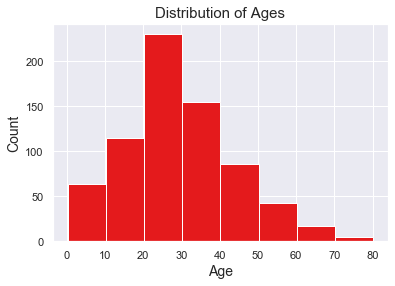

In [1021]:
#take a look at the distribution of Ages aboard
Train_df['Age'].dropna().hist(bins = 8)
plt.title('Distribution of Ages', fontsize = 15)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


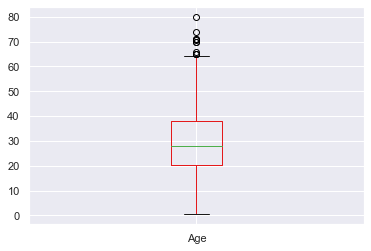

In [1022]:
Train_df['Age'].plot(kind = 'box')
print(Train_df['Age'].describe())

In [1023]:
#apparently ages <1 are in decimals, let's take a look
Train_df.loc[Train_df['Age'] < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


In [1024]:
#children <1 who's age is >0.5 -> I change into 1 years of age
Train_df.loc[(Train_df['Age'] > 0.5) & (Train_df['Age'] < 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


In [1025]:
indices = [78, 305, 469, 644, 755, 831]
Train_df.loc[indices, 'Age'] = 1

In [1026]:
#children <1 who's age is <=0.5 -> I change into 0 years of age
Train_df.loc[Train_df['Age'] <= 0.5 ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C


In [1027]:
indice = [803]
Train_df.loc[indice, 'Age'] = 0

In [1028]:
#check if it worked
Train_df.loc[Train_df['Age'] <= 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,1.0,0,2,248738,29.0000,NaN,S
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
183,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,1.0,1,2,113781,151.5500,C22 C26,S
381,382,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,1.0,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,1.0,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,1.0,1,1,250649,14.5000,NaN,S


In [1029]:
#I make a temporary, seperate df for the NaN values in the Age column
Age_nan = Train_df.loc[Train_df['Age'].isnull()]
Age_nan.reset_index(drop = True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
1,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
2,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7225.0000,NaN,C
3,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7225.0000,NaN,C
4,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [1030]:
#extracting the titles from the Name column in this temporary df to see which Titles have missing ages and how 
#many values are missing

Age_nan['Title'] = Age_nan['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
#thanks to code from Kaggle: https://www.kaggle.com/tuckerarrants/binary-classification-with-titanic-disaster

Age_nan['Title'].value_counts()

C:\Users\laura\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64

In [1031]:
#I extract the titles of the Name column in the original dataframe and put them in a new column 'Title'
Train_df['Title'] = Train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

#thanks to code from Kaggle: https://www.kaggle.com/tuckerarrants/binary-classification-with-titanic-disaster

In [1032]:
#let's see what titles are in the Name column of the original df
Train_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Mme               1
Sir               1
Don               1
Ms                1
Lady              1
the Countess      1
Jonkheer          1
Capt              1
Name: Title, dtype: int64

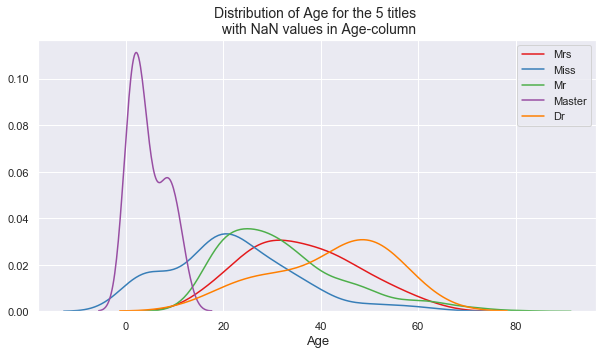

In [1033]:
#let's take a look at the distribution of ages of the 5 titles that have NaN-values in the Age-column
plt.figure(figsize = (10,5))
plt.title('Distribution of Age for the 5 titles \n with NaN values in Age-column', fontsize = 14)
plt.xlabel('Age', fontsize = 13)
sns.kdeplot(Train_df.loc[Train_df['Title'] == 'Mrs']['Age'].dropna(), label = 'Mrs', shade = False)
sns.kdeplot(Train_df.loc[Train_df['Title'] == 'Miss']['Age'].dropna(), label = 'Miss', shade = False)
sns.kdeplot(Train_df.loc[Train_df['Title'] == 'Mr']['Age'].dropna(), label = 'Mr', shade = False)
sns.kdeplot(Train_df.loc[Train_df['Title'] == 'Master']['Age'].dropna(), label = 'Master', shade = False)
sns.kdeplot(Train_df.loc[Train_df['Title'] == 'Dr']['Age'].dropna(), label = 'Dr', shade = False)

plt.show()

There seems to be some relationship between Title and Age. For example, Masters are mainly male children between 0 and 18, and Miss's are on average younger than Mrs's.

In [1034]:
#print the median ages for the titles in the above graph
print('average age Mrs is:', round(Train_df.loc[Train_df['Title'] == 'Mrs']['Age'].dropna().median()))
print('average age Miss is:', round(Train_df.loc[Train_df['Title'] == 'Miss']['Age'].dropna().median()))
print('average age Mr is:', round(Train_df.loc[Train_df['Title'] == 'Mr']['Age'].dropna().median()))
print('average age Master is:', round(Train_df.loc[Train_df['Title'] == 'Master']['Age'].dropna().median()))
print('average age Dr is:', round(Train_df.loc[Train_df['Title'] == 'Dr']['Age'].dropna().median()))

average age Mrs is: 35
average age Miss is: 21
average age Mr is: 30
average age Master is: 4
average age Dr is: 46


I choose to replace the NaN values of the Age column with the median age for each title

In [1035]:
#Mrs
Mrs = Train_df.loc[(Train_df['Title'] == 'Mrs') & (Train_df['Age'].isnull())]
Mrs = Mrs.index

Train_df.loc[Mrs,5:6] = 35

In [1036]:
#Miss
Miss = Train_df.loc[(Train_df['Title'] == 'Miss') & (Train_df['Age'].isnull())]
Miss = Miss.index

Train_df.loc[Miss,5:6] = 21

In [1037]:
#Mr
Mr = Train_df.loc[(Train_df['Title'] == 'Mr') & (Train_df['Age'].isnull())]
Mr = Mr.index

Train_df.loc[Mr,5:6] = 30

In [1038]:
#Master
Master = Train_df.loc[(Train_df['Title'] == 'Master') & (Train_df['Age'].isnull())]
Master = Master.index

Train_df.loc[Master,5:6] = 4

In [1039]:
#Dr
Dr = Train_df.loc[(Train_df['Title'] == 'Dr') & (Train_df['Age'].isnull())]
Dr = Dr.index

Train_df.loc[Dr,5:6] = 46

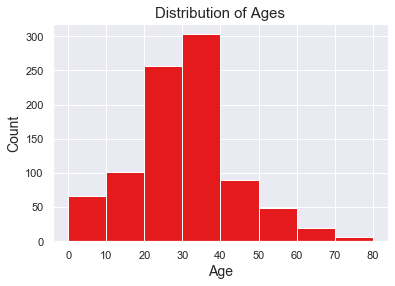

In [1040]:
#and check the overall distribution of the ages again, this time with no NaN values
Train_df['Age'].hist(bins = 8)
plt.title('Distribution of Ages', fontsize = 15)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

count    891.000000
mean      29.392817
std       13.258282
min        0.000000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


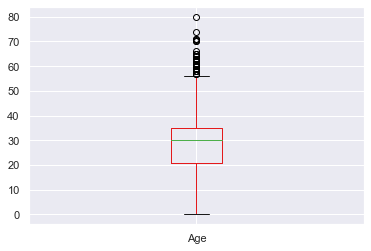

In [1041]:
Train_df['Age'].plot(kind = 'box')
print(Train_df['Age'].describe())

_______________________________________________________

### 1b. NaN values in Cabin column

In [1042]:
#check how many values we have in the Cabin column
print('number of values:',Train_df['Cabin'].notnull().sum())
print('percentage of total observations:',round(Train_df['Cabin'].notnull().sum()/len(Train_df)*100,2))

number of values: 204
percentage of total observations: 22.9


Due to the many NaN vaues, this column might not be useful for modelling. 
I explore it anyway just to see whether there is some hidden information.

In [1043]:
#take a look at the rows which have a Cabin value by making a seperate df
Cabin_values = Train_df.loc[Train_df['Cabin'].notnull()]
Cabin_values.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,Miss


In [1044]:
#take a look at the rows which have NO Cabin value by making a seperatie df
Cabin_nan = Train_df.loc[Train_df['Cabin'].isnull()]
Cabin_nan.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7925.0000,NaN,S,Miss
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,8.4583,NaN,Q,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21075.0000,NaN,S,Master


Passengers with a KNOWN Cabin-value:
1    136
0     68
Name: Survived, dtype: int64
******************************
Passengers with an UNKNOWN Cabin-value:
0    481
1    206
Name: Survived, dtype: int64



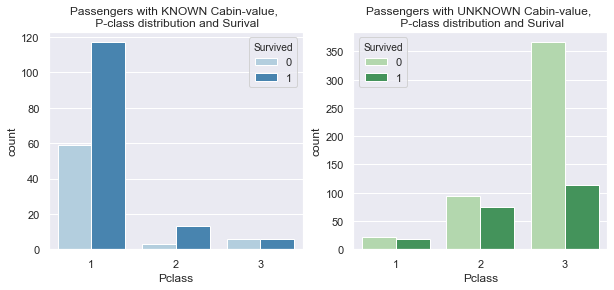

In [1045]:
#let's visualize how the passengers with and without Cabin value relate to P-class and Survival
print('Passengers with a KNOWN Cabin-value:')
print(Cabin_values['Survived'].value_counts())
print('*'*30)
print('Passengers with an UNKNOWN Cabin-value:')
print(Cabin_nan['Survived'].value_counts())
print('')

#plot a countplot to visualize
plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
sns.countplot(x = 'Pclass', hue = 'Survived', data = Cabin_values, palette = 'Blues')
plt.title('Passengers with KNOWN Cabin-value, \n P-class distribution and Surival')

plt.subplot(1,2,2)
sns.countplot(x = 'Pclass', hue = 'Survived', data = Cabin_nan, palette = 'Greens')
plt.title('Passengers with UNKNOWN Cabin-value, \n P-class distribution and Surival')

plt.show()

The passengers with a Cabin value were mainly traveling in Pclass 1 and most of them survived

The passengers without a Cabin value were mainly traveling in Pclass 3 and most of them died.

In [1046]:
#I replace the NaN values with 'Unknown'
Train_df['Cabin'] = Train_df['Cabin'].fillna('Unknown')

_________________________________________________________________________________

### 1c. NaN values in Embarked column

In [1047]:
#I extract the 2 values with a missing embarking port
Train_df.loc[Train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [1048]:
#which embarking port is most common?
Train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [1049]:
#I replace the 2 missing values in the Embarked column with the most common value 'Southampton'
indices = [61, 829]
Train_df.loc[indices, 'Embarked'] = 'S'

In [1050]:
#check if it worked
Train_df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

________________________________________________________________________________________

### 1d. Check if all NaN values are dealt with in Train_df

In [1051]:
Train_df.isnull().sum().sum()

0

In [1052]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


____________________________________________________________________

## 2. Exploring the features & Feature Engineering

In [1053]:
#For visualization purposes I add a new column where 0 = died, 1 = survived
Train_df['SurvivedX'] = Train_df['Survived'].replace({0:'Died', 1:'Survived'})

In [1054]:
#For encoding purposes I add a new column for the P-classes
Train_df['PclassX'] = Train_df['Pclass'].replace({1:'1st Class', 2:'2nd Class', 3:'3rd Class'})

In [1055]:
Train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'SurvivedX',
       'PclassX'],
      dtype='object')

### 2a. Sex and Survival

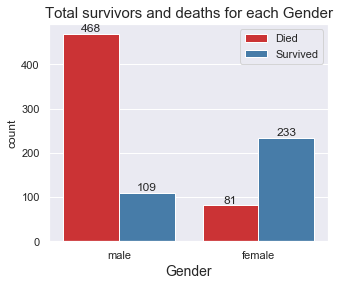

In [1056]:
plt.figure(figsize = (5,4))
title = sns.countplot(x = 'Sex', hue = 'SurvivedX', data = Train_df)
plt.xlabel('Gender', fontsize = 14)
plt.legend()
plt.title('Total survivors and deaths for each Gender', fontsize = 15)
draw(title)

### 2b. Name/Title and Survival

I adjust some of the more rare Titles:

Don, Dr, Rev, Jonkheer, Lady, Sir, the Countess,Capt, Col, Major = Special

Ms, Mlle = Miss

Mme = Mrs

In [1057]:
Train_df['Title'] = Train_df['Title'].replace(['Don','Dr','Rev','Jonkheer','Lady','Sir','the Countess','Capt','Col',
                                               'Major'],['Special','Special','Special','Special','Special','Special',
                                                         'Special','Special','Special','Special'])
Train_df['Title'] = Train_df['Title'].replace(['Ms','Mlle'],['Miss','Miss'])
Train_df['Title'] = Train_df['Title'].replace(['Mme'],['Mrs'])

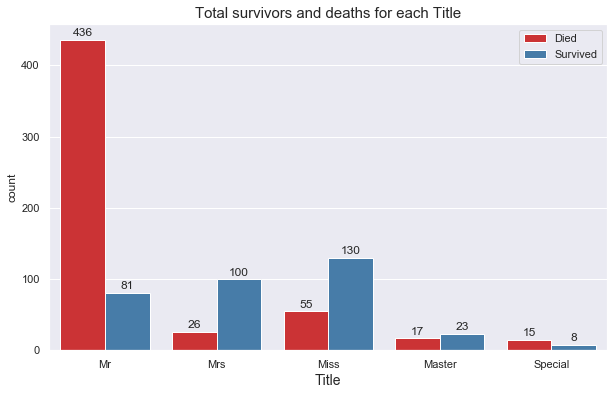

In [1058]:
#plot a countplot with the total count of survivors and deaths for each title
plt.figure(figsize = (10,6))
plt.xlabel('Title', fontsize = 14)
plt.title('Total survivors and deaths for each Title', fontsize = 15)
title2 = sns.countplot(x = 'Title', hue = 'SurvivedX', data = Train_df)
plt.legend()
draw(title2)

### 2c. Age and Survival

In [1059]:
#define agegroups
agegroup = [-1,12,21,35,60,81] #start with -1 to include 0
labels = ['child','young','adult','mid-age','senior']
Train_df['Agegroup'] = pd.cut(Train_df['Age'], agegroup, labels = labels)

In [1060]:
#show how many passengers fall within each agegroup
Agegroups_count = Train_df.groupby(['Agegroup'])[['Sex']].count()
Agegroups_count = Agegroups_count.rename(columns = {'Sex':'Count'})
Agegroups_count

,Count
Agegroup,
child,73
young,171
adult,429
mid-age,196
senior,22


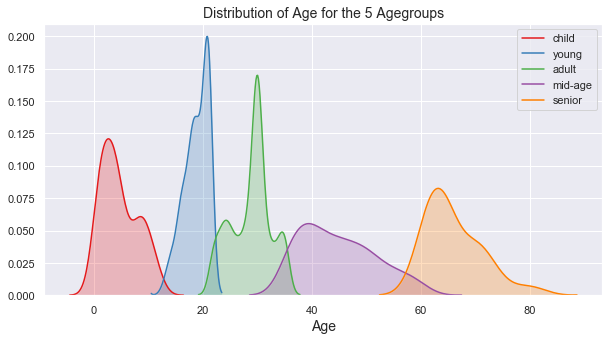

In [1061]:
#let's take a look at the distribution of ages of the 5 Agegroups
plt.figure(figsize = (10,5))
plt.title('Distribution of Age for the 5 Agegroups', fontsize = 14)
plt.xlabel('Age', fontsize = 14)
sns.kdeplot(Train_df.loc[Train_df['Agegroup'] == 'child']['Age'], label = 'child', shade = True)
sns.kdeplot(Train_df.loc[Train_df['Agegroup'] == 'young']['Age'], label = 'young', shade = True)
sns.kdeplot(Train_df.loc[Train_df['Agegroup'] == 'adult']['Age'], label = 'adult', shade = True)
sns.kdeplot(Train_df.loc[Train_df['Agegroup'] == 'mid-age']['Age'], label = 'mid-age', shade = True)
sns.kdeplot(Train_df.loc[Train_df['Agegroup'] == 'senior']['Age'], label = 'senior', shade = True)

plt.show()

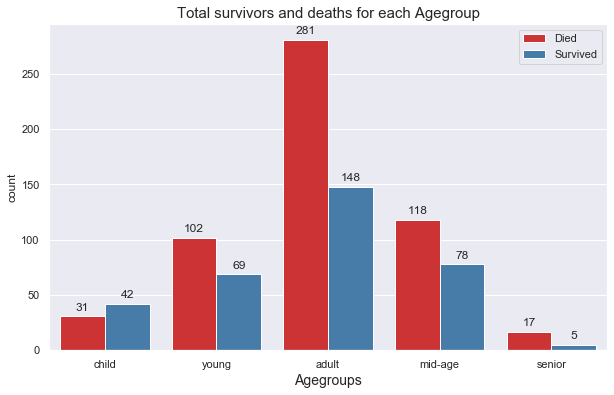

In [1062]:
plt.figure(figsize = (10,6))
age = sns.countplot(x = 'Agegroup', hue = 'SurvivedX', data = Train_df)
plt.legend()
plt.xlabel('Agegroups', fontsize = 14)
plt.title('Total survivors and deaths for each Agegroup', fontsize = 15)
draw(age)

### 2d. Family and Survival

In [1063]:
#I make a new column 'Family size' which shows the family size (a family size of 1 is a passenger travelling alone)
Train_df['Family_size'] = Train_df['SibSp'] + Train_df['Parch'] + 1

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


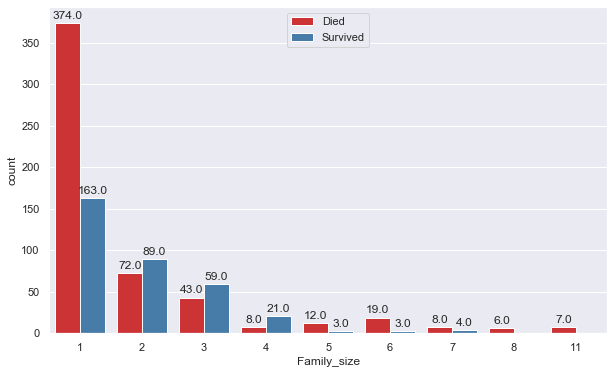

In [1064]:
plt.figure(figsize = (10,6))
family = sns.countplot(x = 'Family_size', hue = 'SurvivedX', data = Train_df)
plt.legend()
draw(family)

It seems that traveling alone, and families of 2,3 and 4 had a quite an impact on survival chances.

I will use this information to make 3 groups: alone (1), reg_fam(2,3,4), big_fam(5,6,7,8,11)

In [1065]:
Train_df['Family_sizeX'] = Train_df['Family_size'].replace([1],['alone'])
Train_df['Family_sizeX'] = Train_df['Family_sizeX'].replace([2,3,4],['reg_fam','reg_fam','reg_fam'])
Train_df['Family_sizeX'] = Train_df['Family_sizeX'].replace([5,6,7,8,11],['big_fam','big_fam','big_fam','big_fam','big_fam'])

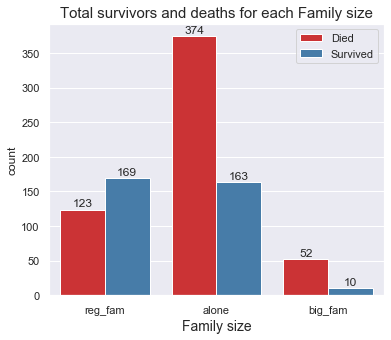

In [1066]:
plt.figure(figsize = (6,5))
family = sns.countplot(x = 'Family_sizeX', hue = 'SurvivedX', data = Train_df)
plt.legend()
plt.xlabel('Family size', fontsize = 14)
plt.title('Total survivors and deaths for each Family size', fontsize = 15)
draw(family)

### 2e.1. Fare and Survival

Text(0.5, 1.0, 'Distribution of Fare prices')

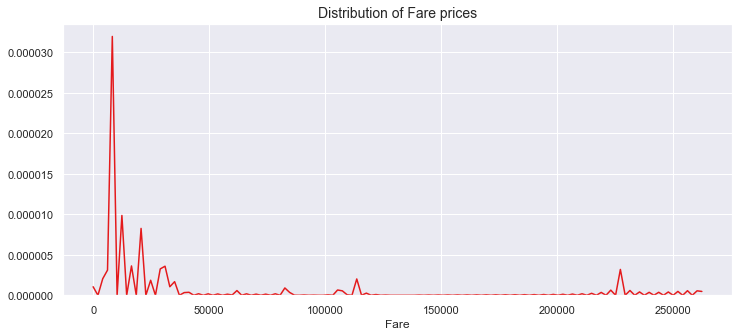

In [1067]:
plt.figure(figsize = (12,5))
sns.distplot(Train_df['Fare'], hist = False)
plt.title('Distribution of Fare prices', fontsize = 14)

In [1068]:
Train_df['Fare'].describe()

count       891.000000
mean       4026.270117
std       22153.876204
min           0.000000
25%           8.050000
50%          19.500000
75%          56.929200
max      262375.000000
Name: Fare, dtype: float64

The distribution is extremely right skewed. I want to see the distribution of the more common fare prices

In [1069]:
#define what is common fare price
common_fare = Train_df.loc[Train_df['Fare'] < 100]

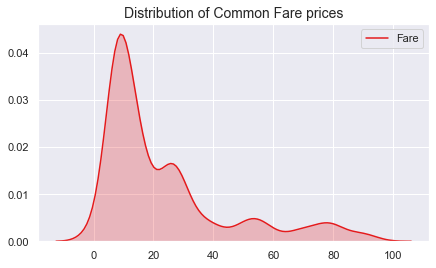

In [1070]:
#distribution of common fare price
plt.figure(figsize = (7,4))
sns.kdeplot(common_fare['Fare'], shade = True)
plt.title('Distribution of Common Fare prices', fontsize = 14)
plt.show()

In [1071]:
#How many observations have a common fare price?
print(common_fare.shape[0])


740


In [1072]:
#I divide the fareprices in 3 groups
faregroup = [-1,500,50000,270000]
labels = ['common','high','extreme']
Train_df['FaregroupX'] = pd.cut(Train_df['Fare'], faregroup, labels = labels)

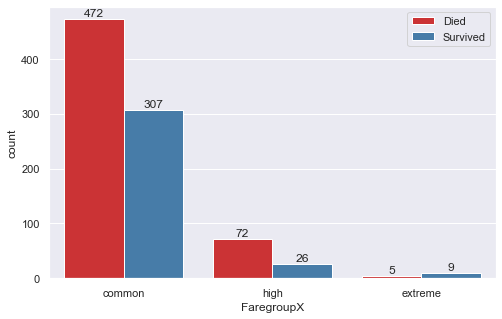

In [1073]:
plt.figure(figsize = (8,5))
faregroup = sns.countplot(x = 'FaregroupX', hue = 'SurvivedX', data = Train_df)
plt.legend()
draw(faregroup)

### 2e.2. Fare and Pclass

In [1074]:
#let's see if there is any relation between traveling first Class and Fareprices
Train_df.groupby(['PclassX'])['FaregroupX'].value_counts()

PclassX    FaregroupX
1st Class  common        197
           extreme        14
           high            5
2nd Class  common        181
           high            3
3rd Class  common        401
           high           90
Name: FaregroupX, dtype: int64

All the passengers who payed extreme prices were traveling in 1st Class. 

It is remarkable that 90 passengers payed a fareprice in the 'high' group (500-50.000) and were traveling 3rd Class.

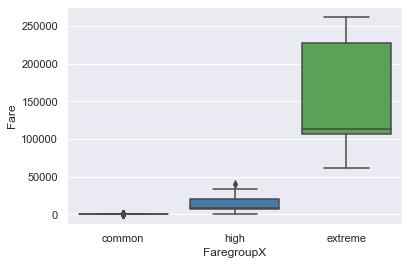

In [1075]:
sns.boxplot(x = Train_df['FaregroupX'], y = Train_df['Fare'])

### 2f. Cabin, Pclass and Survival

In [1076]:
#I extract the letters from the Cabin values, they refer to the decks (with exception of 'U', which stands for unknown)
Train_df['CabinX'] = Train_df['Cabin'].apply(lambda x: x[0])
Train_df['CabinX'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [1077]:
#let's see how what Cabins were in which Pclass and how many survived
Cabin_survival = Train_df.groupby(['CabinX','Pclass'])['SurvivedX'].value_counts()
Cabin_survival = Cabin_survival.unstack()
Cabin_survival = Cabin_survival.fillna(0)
Cabin_survival

SurvivedX       Died  Survived
CabinX Pclass                 
A      1         8.0       7.0
B      1        12.0      35.0
C      1        24.0      35.0
D      1         7.0      22.0
       2         1.0       3.0
E      1         7.0      18.0
       2         1.0       3.0
       3         0.0       3.0
F      2         1.0       7.0
       3         4.0       1.0
G      3         2.0       2.0
T      1         1.0       0.0
U      1        21.0      19.0
       2        94.0      74.0
       3       366.0     113.0

Pclass 1 was mainly on Decks A t/m E and T, so I group these decks together (Decks_luxe)

Decks F and G had mainly Pclass 2 and 3 so I group these together with U (Decks_budget)

In [1078]:
Train_df['CabinX'] = Train_df['CabinX'].replace(['A','B','C','D','E','F','G','T','U'],
                                                  ['Decks_luxe','Decks_luxe','Decks_luxe','Decks_luxe','Decks_luxe','Decks_budget','Decks_budget','Decks_luxe','Decks_budget'])

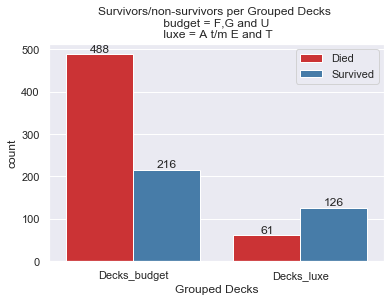

In [1079]:
#let's see how the  grouped Decks relates to Survival
plt.figure(figsize = (6,4))
grouped_decks = sns.countplot(x = 'CabinX', hue = 'SurvivedX', data = Train_df)
plt.xlabel('Grouped Decks')
plt.legend()
plt.title('Survivors/non-survivors per Grouped Decks \n budget = F,G and U \n luxe = A t/m E and T')
draw(grouped_decks)

### 2g. Embarked and Survival

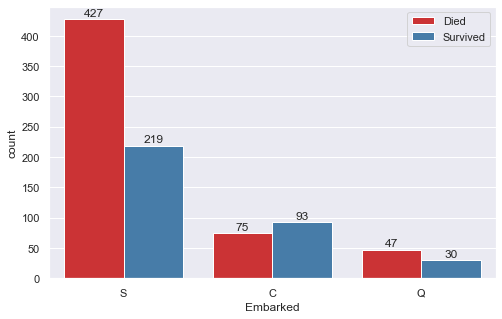

In [1080]:
plt.figure(figsize = (8,5))
embark = sns.countplot(x = 'Embarked', hue = 'SurvivedX', data = Train_df)
plt.legend()
draw(embark)

In [1081]:
#let's check the survival rates based on Embarking port
print('Survival rate Southampton',round(219/(427+219)*100,1),'%')
print('Survival rate Cherbourgh',round(93/(75+93)*100,1),'%')
print('Survival rate Queenstown',round(30/(47+30)*100,1),'%')

Survival rate Southampton 33.9 %
Survival rate Cherbourgh 55.4 %
Survival rate Queenstown 39.0 %


In [1082]:
#let's also check how the different Pclasses were represented by the passengers embarking in the different ports
Emb_class = Train_df.groupby(['PclassX','SurvivedX'])['Embarked'].value_counts()
Emb_class = Emb_class.unstack()
Emb_class

Embarked              C   Q    S
PclassX   SurvivedX             
1st Class Died       26   1   53
          Survived   59   1   76
2nd Class Died        8   1   88
          Survived    9   2   76
3rd Class Died       41  45  286
          Survived   25  27   67

The high survival rate of Cherbourgh passengers might have something to do with most of the passengers traveling in Pclass 1. 

It's interesting that 81% of the 3rd class passengers embarked in Southampton died, while for Cherbourgh and Queenstown this percentage of 3rd class deaths is respectively 62% and 63%. It might have something to do with Southampton being the first embarking port.

_______________________________________________________________________________________________


Countplots of survival for different columns


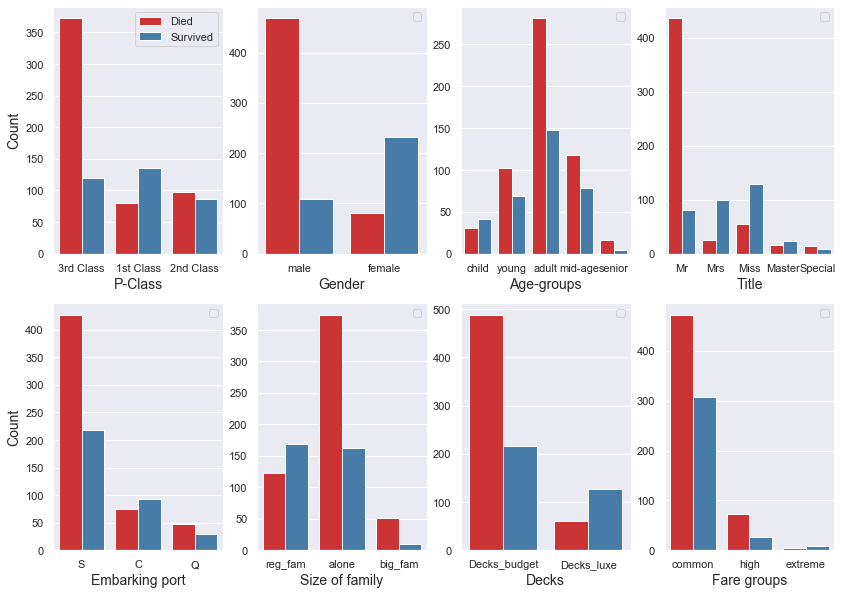

In [1083]:
#plot countplots the 8 columns to visualize who survived and who died
print('')
print('Countplots of survival for different columns')

plt.figure(figsize = (14,10))

plt.subplot(2,4,1)
sns.countplot(x = 'PclassX', hue = 'SurvivedX', data = Train_df )
plt.legend()
plt.xlabel('P-Class', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('')

plt.subplot(2,4,2)
sns.countplot(x = 'Sex', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Gender', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.subplot(2,4,3)
sns.countplot(x = 'Agegroup', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Age-groups', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.subplot(2,4,4)
sns.countplot(x = 'Title', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Title', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.subplot(2,4,5)
sns.countplot(x = 'Embarked', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Embarking port', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('')

plt.subplot(2,4,6)
sns.countplot(x = 'Family_sizeX', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Size of family', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.subplot(2,4,7)
sns.countplot(x = 'CabinX', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Decks', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.subplot(2,4,8)
sns.countplot(x = 'FaregroupX', hue = 'SurvivedX', data = Train_df)
plt.legend('')
plt.xlabel('Fare groups', fontsize = 14)
plt.ylabel('')
plt.title('')

plt.show()

## 3. Transform Train_df into One-Hot Encoded dataframe

In [1084]:
Train_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,SurvivedX,PclassX,Agegroup,Family_size,Family_sizeX,FaregroupX,CabinX
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,Unknown,S,Mr,Died,3rd Class,adult,2,reg_fam,common,Decks_budget


### 3a. Define the features

In [1085]:
Train_df = Train_df[['Survived','PclassX','Sex','Title','Agegroup','Family_sizeX','FaregroupX','CabinX','Embarked']]
Train_df.sample(5)

,Survived,PclassX,Sex,Title,Agegroup,Family_sizeX,FaregroupX,CabinX,Embarked
476,0,2nd Class,male,Mr,adult,reg_fam,common,Decks_budget,S
875,1,3rd Class,female,Miss,young,alone,high,Decks_budget,C
352,0,3rd Class,male,Mr,young,reg_fam,common,Decks_budget,C
249,0,2nd Class,male,Special,mid-age,reg_fam,common,Decks_budget,S
499,0,3rd Class,male,Mr,adult,alone,common,Decks_budget,S


### 3b. One-Hot Encoding Categorical Features

In [1086]:
Train_onehot = pd.get_dummies(Train_df[['PclassX','Sex','Title','Agegroup','Family_sizeX','CabinX',
                                        'Embarked']],prefix="", prefix_sep="")

In [1087]:
#put the target variable into the One-Hot dataframe
Train_onehot['Survived'] = Train_df['Survived']

In [1088]:
Train_onehot.head(3)

,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S,Survived
0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1
2,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1


In [1089]:
print(Train_onehot.shape)

(891, 24)


In [1090]:
Train_onehot.columns

Index(['1st Class', '2nd Class', '3rd Class', 'female', 'male', 'Master',
       'Miss', 'Mr', 'Mrs', 'Special', 'child', 'young', 'adult', 'mid-age',
       'senior', 'alone', 'big_fam', 'reg_fam', 'Decks_budget', 'Decks_luxe',
       'C', 'Q', 'S', 'Survived'],
      dtype='object')

### 3c. Check correlation to 'Survived'

In [1091]:
Train_corr = round(Train_onehot.corr(),2)
Corr_Survived = Train_corr.tail(1)
Corr_Survived = Corr_Survived.transpose()

In [1092]:
Corr_Survived = Corr_Survived.sort_values('Survived', ascending = False)
Corr_Survived = Corr_Survived.drop(Corr_Survived.index[0])

Corr_Survived = Corr_Survived.rename(columns = {'Survived':'Corr to Survived'})

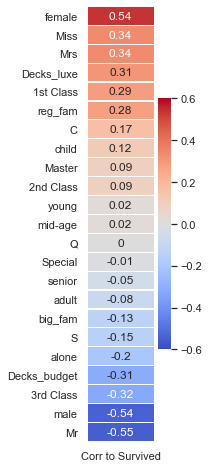

In [1093]:
plt.figure(figsize = (1.5,8))
sns.heatmap(Corr_Survived, center = 0, vmin = -0.6, vmax = 0.6, annot = True, cmap = 'coolwarm', linewidths = 0.2)

______________________________________________________________

## 4. Form Clusters and add to One-Hot dataframe

In [1094]:
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Train_onehot)

In [1095]:
#check the generated cluster labels
kmeans.labels_[0:10]

array([1, 0, 2, 0, 1, 1, 0, 1, 2, 2])

In [1096]:
#create a temporary dataframe for the clusters
Clusters = pd.DataFrame(kmeans.labels_)
Clusters = Clusters.rename(columns = {0:'Cluster'})
Clusters = Clusters.replace([0,1,2],['null','one','two'])

In [1097]:
Clusters.sample(5)

,Cluster
646,one
624,one
793,one
488,one
816,two


In [1098]:
#one-hot encoding for the cluster labels
Clusters = pd.get_dummies(Clusters[['Cluster']])

In [1099]:
Clusters.head()

,Cluster_null,Cluster_one,Cluster_two
0,0,1,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [1100]:
#merge the one-hot encoded clusters with the Train_onehot dataframe
Train_onehot = pd.merge(Clusters, Train_onehot, right_index = True, left_index = True)

In [1101]:
Train_onehot.sample(3)

,Cluster_null,Cluster_one,Cluster_two,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S,Survived
629,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
137,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0
812,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [1102]:
Train_onehot.shape

(891, 27)

______________________________________________________________________________________

## 5. Machine Learning Evaluation on Train_df

### 5a. Define X and y, and Train-Test-Split

In [1103]:
#using all the features from the One-Hot dataframe
X = Train_onehot.iloc[:,:-1]
y = Train_onehot['Survived']

In [1104]:
X.head(2)

,Cluster_null,Cluster_one,Cluster_two,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S
0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0


In [1105]:
#split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=4)

print('Train set:',X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (605, 26) (605,)
Test set: (286, 26) (286,)


### 5b. Logistic Regression model, prediction and evaluation

In [1106]:
Log_Reg = LogisticRegression(C=0.3, solver = 'liblinear')
Log_Reg.fit(X_train, y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [1107]:
yhat1 = Log_Reg.predict(X_test)
yhat1[0:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

In [1108]:
#predict_proba returns estimates for all classes
yhat1_prob = Log_Reg.predict_proba(X_test)
yhat1_prob[0:5]

array([[0.92, 0.08],
       [0.92, 0.08],
       [0.36, 0.64],
       [0.1 , 0.9 ],
       [0.82, 0.18]])

In [1109]:
#print a classification report
print(classification_report(y_test, yhat1))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       189
           1       0.80      0.78      0.79        97

    accuracy                           0.86       286
   macro avg       0.85      0.84      0.84       286
weighted avg       0.86      0.86      0.86       286



In [1110]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('(Confusion Matrix without normalization)')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2
    for i,j, in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(Confusion Matrix without normalization)
[[ 76  21]
 [ 19 170]]


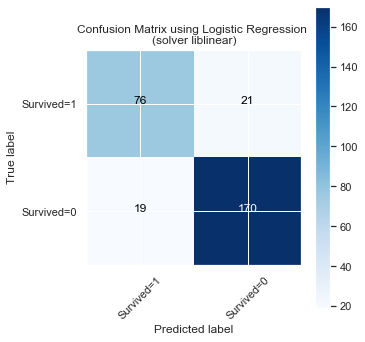

In [1111]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat1, labels=[1,0])
np.set_printoptions(precision=2)

#plot confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Survived=1','Survived=0'], normalize=False, 
                      title='Confusion Matrix using Logistic Regression \n(solver liblinear)')

### 5c. Random Forest model, prediction and evaluation

In [1112]:
Rand_For = RandomForestClassifier()
Rand_For.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1113]:
yhat2 = Rand_For.predict(X_test)
yhat2[0:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int64)

In [1114]:
#predict_proba returns estimates for all classes
yhat2_prob = Rand_For.predict_proba(X_test)
yhat2_prob[0:5]

array([[0.92, 0.08],
       [0.92, 0.08],
       [0.21, 0.79],
       [0.14, 0.86],
       [1.  , 0.  ]])

In [1115]:
#print a classification report
print(classification_report(y_test, yhat2))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       189
           1       0.75      0.71      0.73        97

    accuracy                           0.82       286
   macro avg       0.80      0.79      0.80       286
weighted avg       0.82      0.82      0.82       286



(Confusion Matrix without normalization)
[[ 69  28]
 [ 23 166]]


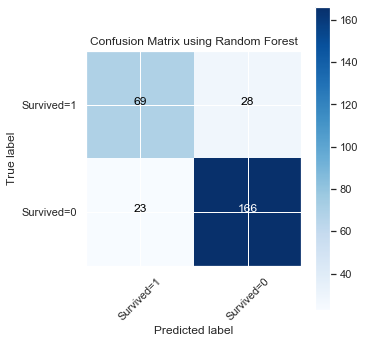

In [1116]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2, labels=[1,0])
np.set_printoptions(precision=2)

#plot confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Survived=1','Survived=0'], normalize=False, 
                      title='Confusion Matrix using Random Forest')

### 5d. K-Nearest Neighbor model, prediction and evaluation

In [1117]:
Ks=20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range (1, Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat3 = neigh.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test,yhat3)
    std_acc[n-1]=np.std(yhat3==y_test)/np.sqrt(yhat3.shape[0])

print('The mean accuracy for the different Ks are:',mean_acc)

The mean accuracy for the different Ks are: [0.81 0.8  0.83 0.84 0.84 0.85 0.85 0.85 0.86 0.85 0.86 0.87 0.87 0.87
 0.87 0.87 0.86 0.87 0.86]


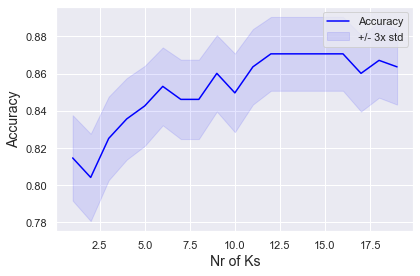

In [1118]:
#plot the accuracy of different K's with +/- 3x std
plt.figure(figsize=(6,4))
plt.plot(range(1,Ks),mean_acc, color='blue')
plt.fill_between(range(1,Ks), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10, color='blue')

plt.legend(('Accuracy','+/- 3x std'))
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Nr of Ks', fontsize=14)
plt.tight_layout()
plt.show()

In [1119]:
print('The best accuracy is', round(mean_acc.max(),2),'with k =', mean_acc.argmax()+1)

The best accuracy is 0.87 with k = 12


In [1120]:
k= mean_acc.argmax()+1
KNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

In [1121]:
yhat3 = KNN.predict(X_test)
yhat3[0:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

In [1122]:
#predict_proba returns estimates for all classes
yhat3_prob = KNN.predict_proba(X_test)
yhat3_prob[0:5]

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.08, 0.92],
       [0.08, 0.92],
       [0.92, 0.08]])

In [1123]:
print(classification_report(y_test, yhat3))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       189
           1       0.91      0.69      0.78        97

    accuracy                           0.87       286
   macro avg       0.88      0.83      0.85       286
weighted avg       0.87      0.87      0.87       286



(Confusion Matrix without normalization)
[[ 67  30]
 [  7 182]]


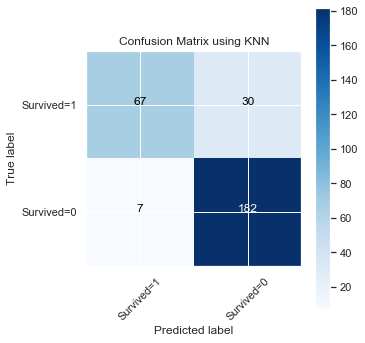

In [1124]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat3, labels=[1,0])
np.set_printoptions(precision=2)

#plot confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Survived=1','Survived=0'], normalize=False, 
                      title='Confusion Matrix using KNN')

### 5e. Super Vector Machine model, prediction and evaluation

In [1125]:
SVM = svm.SVC(kernel='linear', probability = True)
SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [1126]:
yhat4 = SVM.predict(X_test)
yhat4[0:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

In [1127]:
#predict_proba returns estimates for all classes
yhat4_prob = SVM.predict_proba(X_test)
yhat4_prob[0:5]

array([[0.81, 0.19],
       [0.81, 0.19],
       [0.26, 0.74],
       [0.26, 0.74],
       [0.81, 0.19]])

In [1128]:
print(classification_report(y_test, yhat4))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       189
           1       0.87      0.74      0.80        97

    accuracy                           0.87       286
   macro avg       0.87      0.84      0.85       286
weighted avg       0.87      0.87      0.87       286



(Confusion Matrix without normalization)
[[ 72  25]
 [ 11 178]]


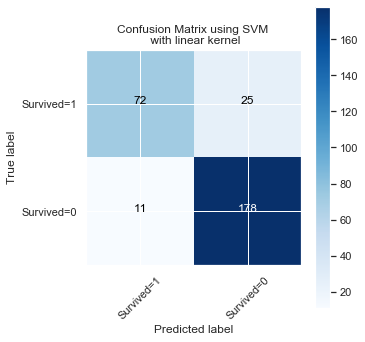

In [1129]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat4, labels=[1,0])
np.set_printoptions(precision=2)

#plot confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Survived=1','Survived=0'], normalize=False, 
                      title='Confusion Matrix using SVM \n with linear kernel')

### 5f. Model Evaluation Summary: F1-scores and ROC-AUC-scores

In [1130]:
print('AVG weighted F1 score for the different models:')
print('')
print('LogReg with liblinear solver:',round(f1_score(y_test, yhat1, average='weighted'),3))
print('Random Forest:',round(f1_score(y_test, yhat2, average='weighted'),3))
print('KNN:',round(f1_score(y_test, yhat3, average='weighted'),2))
print('SVM with linear-kernel:',round(f1_score(y_test, yhat4, average='weighted'),3))


AVG weighted F1 score for the different models:

LogReg with liblinear solver: 0.86
Random Forest: 0.82
KNN: 0.87
SVM with linear-kernel: 0.871


In [1131]:
print('Area under the ROC curve for the different models:')
print('')
print('LogReg:', round(roc_auc_score(y_test, yhat1, labels=None),3))
print('Random Forest:', round(roc_auc_score(y_test, yhat2, labels=None),3))
print('KNN:', round(roc_auc_score(y_test, yhat3, labels=None),3))
print('SVM:', round(roc_auc_score(y_test, yhat4, labels=None),3))

Area under the ROC curve for the different models:

LogReg: 0.841
Random Forest: 0.795
KNN: 0.827
SVM: 0.842


### 5g. Conclusion

The ROC-AUC-scores suggest the SVM model is the most accurate at this point. This is in line with the calculated weighted F1-scores.

I will use all 4 models for predicting values in the Test_df dataset to see if the expected outcomes are similiar to this conclusion.

_______________________________________________________________________

__________________________________________________________________

# Titanic Test_df

In [917]:
Test_df = pd.read_csv('test set Titanic.csv')

In [918]:
Test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [919]:
Test_df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,1069,1,"Stengel, Mr. Charles Emil Henry",male,54.0,1,0,11778,55.4417,C116,C
216,1108,3,"Mahon, Miss. Bridget Delia",female,NaN,0,0,330924,7.8792,NaN,Q
194,1086,2,"Drew, Master. Marshall Brines",male,8.0,0,2,28220,32.5000,NaN,S
21,913,3,"Olsen, Master. Artur Karl",male,9.0,0,1,C 17368,3.1708,NaN,S
256,1148,3,"Mahon, Mr. John",male,NaN,0,0,AQ/4 3130,7.7500,NaN,Q


In [920]:
Test_df.shape

(418, 11)

In [921]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


________________________________________________________________

## 6. NaN values

### 6a. NaN values in Age column

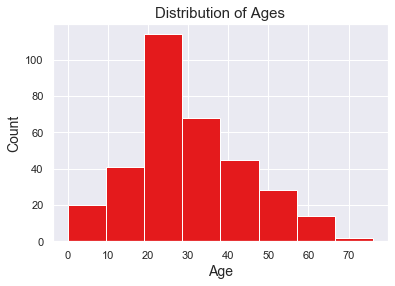

In [922]:
#take a look at the distribution of Ages
Test_df['Age'].dropna().hist(bins = 8)
plt.title('Distribution of Ages', fontsize = 15)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

In [923]:
Test_df['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [924]:
#ages <1 are in decimals, let's take a look
Test_df.loc[Test_df['Age'] < 1]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
201,1093,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.33,0,2,347080,14.40,NaN,S
250,1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.75,NaN,S
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13775.00,NaN,S
307,1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.35,NaN,S
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20575.00,NaN,S


In [925]:
#children <1 who's age is >0.5 -> I change into 1 years of age
Test_df.loc[(Test_df['Age'] > 0.5) & (Test_df['Age'] < 1)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
250,1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.75,NaN,S
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13775.00,NaN,S
307,1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.35,NaN,S


In [926]:
indices = [250,281,307]
Test_df.loc[indices, 'Age'] = 1

In [927]:
#children <1 who's age is <=0.5 -> I change into 0 years of age
Test_df.loc[Test_df['Age'] <= 0.5 ]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
201,1093,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.33,0,2,347080,14.4,NaN,S
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20575.0,NaN,S


In [928]:
indices = [201,354]
Test_df.loc[indices, 'Age'] = 0

In [929]:
#I make a temporary, seperate df for the NaN's in the Age column
Age_nan = Test_df.loc[Test_df['Age'].isnull()]
Age_nan.reset_index(drop = True).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
1,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
2,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
3,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
4,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S


In [930]:
#extracting the titles from the Name column in this temporary df to see which Titles have missing ages and how 
#many values are missing
Age_nan['Title'] = Age_nan['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

C:\Users\laura\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [931]:
Age_nan['Title'].value_counts()

Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Title, dtype: int64

In [932]:
#I extract the titles of the Name column in the original dataframe and put them in a seperate column
Test_df['Title'] = Test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

#thanks to code from Kaggle: https://www.kaggle.com/tuckerarrants/binary-classification-with-titanic-disaster

In [933]:
Test_df['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64

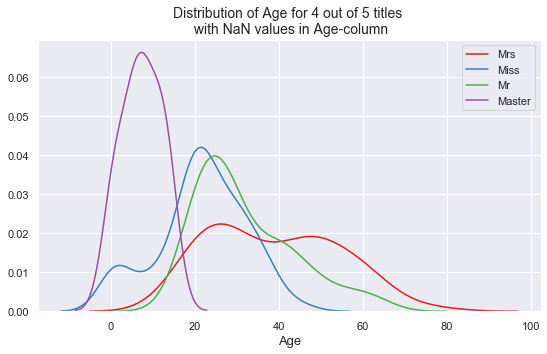

In [934]:
#let's take a look at the distribution of ages of the 5 titles that have NaN values in the Age-column
plt.figure(figsize = (9,5))
plt.title('Distribution of Age for 4 out of 5 titles \n with NaN values in Age-column', fontsize = 14)
plt.xlabel('Age', fontsize = 13)
sns.kdeplot(Test_df.loc[Test_df['Title'] == 'Mrs']['Age'].dropna(), label = 'Mrs', shade = False)
sns.kdeplot(Test_df.loc[Test_df['Title'] == 'Miss']['Age'].dropna(), label = 'Miss', shade = False)
sns.kdeplot(Test_df.loc[Test_df['Title'] == 'Mr']['Age'].dropna(), label = 'Mr', shade = False)
sns.kdeplot(Test_df.loc[Test_df['Title'] == 'Master']['Age'].dropna(), label = 'Master', shade = False)
# sns.kdeplot(Test_df.loc[Test_df['Title'] == 'Ms']['Age'].dropna(), label = 'Ms', shade = False)

plt.show()

In [935]:
#print the average ages for the titles in the above graph
print('average age Mrs is:', round(Test_df.loc[Test_df['Title'] == 'Mrs']['Age'].dropna().mean()))
print('average age Miss is:', round(Test_df.loc[Test_df['Title'] == 'Miss']['Age'].dropna().mean()))
print('average age Mr is:', round(Test_df.loc[Test_df['Title'] == 'Mr']['Age'].dropna().mean()))
print('average age Master is:', round(Test_df.loc[Test_df['Title'] == 'Master']['Age'].dropna().mean()))
print('average age Ms will be the same as average age Miss')

average age Mrs is: 39
average age Miss is: 22
average age Mr is: 32
average age Master is: 7
average age Ms will be the same as average age Miss


In [936]:
#replacing the NaN values for the average Title age

#Mrs
Mrs = Test_df.loc[(Test_df['Title'] == 'Mrs') & (Test_df['Age'].isnull())]
Mrs = Mrs.index

Test_df.loc[Mrs,4:5] = 39

In [937]:
#Miss
Miss = Test_df.loc[(Test_df['Title'] == 'Miss') & (Test_df['Age'].isnull())]
Miss = Miss.index

Test_df.loc[Miss,4:5] = 22

In [938]:
#Mr
Mr = Test_df.loc[(Test_df['Title'] == 'Mr') & (Test_df['Age'].isnull())]
Mr = Mr.index

Test_df.loc[Mr,4:5] = 32

In [939]:
#Master
Master = Test_df.loc[(Test_df['Title'] == 'Master') & (Test_df['Age'].isnull())]
Master = Master.index

Test_df.loc[Master,4:5] = 7

In [940]:
#Ms
Ms = Test_df.loc[(Test_df['Title'] == 'Ms') & (Test_df['Age'].isnull())]
Ms = Ms.index

Test_df.loc[Ms,4:5] = 22

In [941]:
#check if it worked
Test_df.Age.isnull().sum()

0

### 6b. NaN value in Fare column

In [942]:
#let's check the distribution of values in the Fare column
Test_df.Fare.describe()

count       417.000000
mean       5287.624131
std       31282.681233
min           0.000000
25%           8.050000
50%          21.000000
75%          60.000000
max      262375.000000
Name: Fare, dtype: float64

In [943]:
median = Test_df.Fare.median()
median

21.0

In [944]:
#I replace the NaN value with the median Fare price
Test_df['Fare'] = Test_df['Fare'].replace(np.nan, median)

In [945]:
Test_df.Fare.isnull().sum()

0

### 6c. NaN values in Cabin column

In [946]:
#I replace the NaN values with 'Unknown'
Test_df['Cabin'] = Test_df['Cabin'].fillna('Unknown')

In [947]:
#check if all the NaN vlues are dealt with
Test_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

_______________________________________________________________________

In [948]:
#check if all NaN values are dealt with
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


_________________________________________________________________________

## 7. Feature Engineering Test_df

In [949]:
Test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs


### 7a. Pclass

In [950]:
#For encoding purposes I add a new column wfor the P classes
Test_df['PclassX'] = Test_df['Pclass'].replace({1:'1st Class', 2:'2nd Class', 3:'3rd Class'})

In [951]:
Test_df['PclassX'].value_counts()

3rd Class    218
1st Class    107
2nd Class     93
Name: PclassX, dtype: int64

### 7b. Sex

In [952]:
Test_df['Sex'].value_counts()

male      266
female    152
Name: Sex, dtype: int64

### 7c. Age

In [953]:
Test_df.Age.describe()

count    418.000000
mean      30.197368
std       13.019950
min        0.000000
25%       22.000000
50%       30.000000
75%       36.875000
max       76.000000
Name: Age, dtype: float64

In [954]:
#define agegroups
agegroup = [-1,12,21,35,60,81] #start with -1 to include 0
labels = ['child','young','adult','mid-age','senior']
Test_df['Agegroup'] = pd.cut(Test_df['Age'], agegroup, labels = labels)

In [955]:
#show how many passengers fall within each agegroup
Agegroups_count = Test_df.groupby(['Agegroup'])[['Sex']].count()
Agegroups_count = Agegroups_count.rename(columns = {'Sex':'Count'})
Agegroups_count

,Count
Agegroup,
child,29
young,61
adult,213
mid-age,104
senior,11


### 7c. Family

In [956]:
#I make a new column 'Family (by number)' which shows the family size (a family size of 1 is a passenger travelling alone)
Test_df['Family_size'] = Test_df['SibSp'] + Test_df['Parch'] + 1

In [957]:
#check the family sizes
Test_df['Family_size'].unique()

array([ 1,  2,  3,  5,  4,  6,  8,  7, 11], dtype=int64)

In [958]:
#the family sizes are equal to the ones in Train_df so I can use the same labels
Test_df['Family_sizeX'] = Test_df['Family_size'].replace([1],['alone'])
Test_df['Family_sizeX'] = Test_df['Family_sizeX'].replace([2,3,4],['reg_fam','reg_fam','reg_fam'])
Test_df['Family_sizeX'] = Test_df['Family_sizeX'].replace([5,6,7,8,11],['big_fam','big_fam','big_fam','big_fam','big_fam'])

In [959]:
Test_df['Family_sizeX'].value_counts()

alone      253
reg_fam    145
big_fam     20
Name: Family_sizeX, dtype: int64

### 7d. Fare

In [960]:
Test_df.Fare.describe()

count       418.000000
mean       5275.024552
std       31246.211372
min           0.000000
25%           8.050000
50%          21.000000
75%          59.850000
max      262375.000000
Name: Fare, dtype: float64

In [961]:
faregroup = [-1,500,50000,270000]
labels = ['common','high','extreme']
Test_df['FaregroupX'] = pd.cut(Test_df['Fare'], faregroup, labels = labels)

In [962]:
Test_df['FaregroupX'].value_counts()

common     368
high        42
extreme      8
Name: FaregroupX, dtype: int64

### 7e. Cabin

In [963]:
#I extract the letters from the Cabin values, they refer to the decks (with exception of 'U', which stands for unknown)
Test_df['CabinX'] = Test_df['Cabin'].apply(lambda x: x[0])
Test_df['CabinX'].unique()

array(['U', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

In [964]:
Test_df['CabinX'] = Test_df['CabinX'].replace(['A','B','C','D','E','F','G','U'],
                                                  ['Decks_luxe','Decks_luxe','Decks_luxe','Decks_luxe','Decks_luxe',
                                                   'Decks_budget','Decks_budget','Decks_budget'])

In [965]:
Test_df['CabinX'].value_counts()

Decks_budget    336
Decks_luxe       82
Name: CabinX, dtype: int64

### 7f. Embarked

In [966]:
#check if the spread across the Pclasses is the same for the embarking ports in Train_df
Emb_class = Test_df.groupby(['PclassX'])['Embarked'].value_counts()
Emb_class = Emb_class.unstack()
Emb_class

Embarked,C,Q,S
PclassX,,,
1st Class,56,1,50
2nd Class,11,4,78
3rd Class,35,41,142


### 7g. Title

In [967]:
Test_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [968]:
#let's see what titles exist for each agegroup and gender 
title_age = pd.DataFrame(Test_df.groupby(['Title'])['Agegroup'].value_counts())
title_age = title_age.unstack()
title_age = title_age.fillna(0)
title_age

Agegroup                           
Agegroup    adult child mid-age senior young
Title                                       
Col           0.0   0.0     2.0    0.0   0.0
Dona          0.0   0.0     1.0    0.0   0.0
Dr            0.0   0.0     1.0    0.0   0.0
Master        0.0  17.0     0.0    0.0   4.0
Miss         43.0  12.0     6.0    0.0  17.0
Mr          146.0   0.0    53.0    7.0  34.0
Mrs          22.0   0.0    40.0    4.0   6.0
Ms            1.0   0.0     0.0    0.0   0.0
Rev           1.0   0.0     1.0    0.0   0.0

In [969]:
Test_df['Title'] = Test_df['Title'].replace(['Dona','Dr','Rev','Col'],['Special','Special','Special','Special'])
Test_df['Title'] = Test_df['Title'].replace(['Ms'],['Miss'])

In [970]:
Test_df.Title.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Special      6
Name: Title, dtype: int64

____________________________________________________________

In [971]:
Test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PclassX,Agegroup,Family_size,Family_sizeX,FaregroupX,CabinX
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,3rd Class,adult,1,alone,common,Decks_budget
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,3rd Class,mid-age,2,reg_fam,common,Decks_budget


____________________________________________________

## 8. One-Hot Encoding Categorical Features Test_df

In [972]:
#define the features
Test_df = Test_df[['PassengerId','PclassX','Sex','Title','Agegroup','Family_sizeX','FaregroupX','CabinX','Embarked']]
Test_df.sample(5)

,PassengerId,PclassX,Sex,Title,Agegroup,Family_sizeX,FaregroupX,CabinX,Embarked
24,916,1st Class,female,Mrs,mid-age,big_fam,extreme,Decks_luxe,C
145,1037,3rd Class,male,Mr,adult,reg_fam,common,Decks_budget,S
321,1213,3rd Class,male,Mr,adult,alone,common,Decks_budget,C
302,1194,2nd Class,male,Mr,mid-age,reg_fam,common,Decks_budget,S
190,1082,2nd Class,male,Mr,adult,reg_fam,common,Decks_budget,S


In [973]:
Test_onehot = pd.get_dummies(Test_df[['PclassX','Sex','Title','Agegroup','Family_sizeX','CabinX','Embarked']],
                             prefix="", prefix_sep="")
Test_onehot.head(2)

,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S
0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1


## 9. Form Clusters and add to One-Hot dataframe

In [974]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Test_onehot)

In [975]:
#check the generated cluster labels
kmeans.labels_[0:10]

array([1, 2, 1, 1, 2, 1, 2, 1, 2, 1])

In [976]:
#create a temporary dataframe for the clusters
Clusters = pd.DataFrame(kmeans.labels_)
Clusters = Clusters.rename(columns = {0:'Cluster'})
Clusters = Clusters.replace([0,1,2],['null','one','two'])

In [977]:
#one-hot encoding for the cluster labels
Clusters = pd.get_dummies(Clusters[['Cluster']])

In [978]:
Clusters.head()

,Cluster_null,Cluster_one,Cluster_two
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,0,1


In [979]:
#merge the one-hot encoded clusters with the Test_onehot dataframe
Test_onehot = pd.merge(Clusters, Test_onehot, right_index = True, left_index = True)

In [980]:
Test_onehot.sample(3)

,Cluster_null,Cluster_one,Cluster_two,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S
298,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
113,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
337,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0


_____________________________________________________________________

## 10. Predictions & submission accuracy

### 10a. Put PassengerId column back into Test_onehot dataframe

In [981]:
Test_onehot['PassengerId'] = Test_df['PassengerId']

In [982]:
Test_onehot.head(2)

,Cluster_null,Cluster_one,Cluster_two,1st Class,2nd Class,3rd Class,female,male,Master,Miss,Mr,Mrs,Special,child,young,adult,mid-age,senior,alone,big_fam,reg_fam,Decks_budget,Decks_luxe,C,Q,S,PassengerId
0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,892
1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,893


### 10b. Define X_train, y_train and X_test

In [983]:
# reminder: X = Train_onehot.iloc[:,:-1] and y = Train_onehot['Survived']

X_train = X
y_train = y

In [984]:
X_test = Test_onehot.iloc[:,:-1]

In [985]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(891, 26)
(891,)
(418, 26)


### 10c. Logistic Regression

In [986]:
Titanic_LogReg = LogisticRegression(C=0.3, solver = 'liblinear')
Titanic_LogReg.fit(X_train, y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [987]:
LogReg_prediction = Titanic_LogReg.predict(X_test)
LogReg_prediction[0:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [988]:
output = pd.DataFrame({'PassengerId': Test_df.PassengerId, 'Survived': pred_Titanic_Tree})
output.to_csv('LogReg_prediction.csv', index=False)
print('LogReg_prediction.csv successfully saved')

LogReg_prediction.csv successfully saved


In [989]:
LogReg_prediction_df = pd.read_csv('LogReg_prediction.csv')
LogReg_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [990]:
#distribution survivors/non-survivors with KNN model
LogReg_df = pd.DataFrame(LogReg_prediction_df['Survived'].value_counts())
LogReg_df

,Survived
0,308
1,110


**LogReg accuracy: 0.7799**

### 10d. Random Forest

In [991]:
Titanic_Forest = RandomForestClassifier()
Titanic_Forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [992]:
pred_Titanic_Forest = Titanic_Forest.predict(X_test)
pred_Titanic_Forest[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [993]:
output = pd.DataFrame({'PassengerId': Test_df.PassengerId, 'Survived': pred_Titanic_Forest})
output.to_csv('RandomForest_prediction.csv', index=False)
print('RandomForest_prediction.csv successfully saved')

RandomForest_prediction.csv successfully saved


In [994]:
RF_prediction_df = pd.read_csv('RandomForest_prediction.csv')
RF_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [995]:
RF_df = pd.DataFrame(RF_prediction_df['Survived'].value_counts())
RF_df

,Survived
0,288
1,130


**Random Forest accuracy: 0.78468**

### 10e. KNN

In [996]:
print(mean_acc.argmax()+1)

12


In [997]:
k = mean_acc.argmax()+1
Titanic_KNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

In [998]:
predictionsKNN = Titanic_KNN.predict(X_test)
predictionsKNN[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [999]:
output = pd.DataFrame({'PassengerId': Test_df.PassengerId, 'Survived': predictionsKNN})
output.to_csv('KNN12_prediction.csv', index=False)
print('KNN12_prediction.csv successfully saved')

KNN12_prediction.csv successfully saved


In [1000]:
KNN_prediction_df = pd.read_csv('KNN12_prediction.csv')
KNN_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [1001]:
#distribution survivors/non-survivors with KNN model
KNN_df = pd.DataFrame(KNN_prediction_df['Survived'].value_counts())
KNN_df

,Survived
0,293
1,125


**KNN accuracy: 0.78708**

### 10f. SVM

In [1002]:
clf_predict = svm.SVC(kernel='linear')
clf_predict.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1003]:
predictions_SVM = clf_predict.predict(X_test)
predictions_SVM[0:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [1004]:
output = pd.DataFrame({'PassengerId': Test_df.PassengerId, 'Survived': predictions_SVM})
output.to_csv('SVMlinear_prediction.csv', index=False)
print('SVMlinear_prediction.csv successfully saved')

SVMlinear_prediction.csv successfully saved


In [1005]:
SVM_prediction_df = pd.read_csv('SVMlinear_prediction.csv')
SVM_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [1006]:
#distribution of survivors/non-survivors with SVM model
SVM_df = pd.DataFrame(SVM_prediction_df['Survived'].value_counts())
SVM_df

,Survived
0,259
1,159


**SVM accuracy: 0.76794**

_____________________________________________________________________

## 11. Conclusion 

after evaluation with ROC-AUC-scores, the accuracy using Train-Test-Split on the Train_df dataframe was:

1. SVM: 0.842
2. LogReg: 0.841
3. KNN: 0.827
4. Random Forest: 0.793


Submission of the model predictions on the Test_df dataframe leads to an actual accuracy of:

1. KNN: 0.787
2. Random Forest: 0.785
3. LogReg: 0.780
4. SVM: 0.768


So, the actual accuracy of the models after submission is almost the other way around. Only the Random Forest model is close to the accuracy on Train_df.

Let's say: still lots to learn, work in progress!